# A VAE implementation that generates non-existent digits from N(0,1) on the MNIST dataset.

## Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random

## Hyperparameters

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
learning_rate = 0.001
num_epochs = 20

## Preprocessing

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()
     ])

dataset_train = datasets.MNIST('.',
                               train=True,
                               download=True,
                               transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2,
                                          drop_last = True,)

dataset_test = datasets.MNIST('.',
                              train=False,
                              download=True,
                              transform=transform)
testloader = torch.utils.data.DataLoader(dataset_test,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2,
                                          drop_last = True,)

## VAE Implementation with Convolutional and Fully Connected Layers

In [ ]:
class Encoder(nn.Module):
    def __init__(self, imgChannels, featureDim, zDim):
        super(Encoder, self).__init__()
        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

    def forward(self, x):
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 32*20*20)
        mu = self.encFC1(x)
        log_sigma = self.encFC2(x)
        return mu, log_sigma


class Decoder(nn.Module):
    def __init__(self, imgChannels, featureDim, zDim):
        super(Decoder, self).__init__()

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 5)

    def forward(self, x):
        # print(x.size())
        x = F.relu(self.decFC1(x))
        x = x.view(-1, 32, 20, 20)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x

#Reparameterization takes in the input mu and logVar and sample the mu + std * eps
def reparameterize(mu, log_sigma):
    std = torch.exp(log_sigma)
    eps = torch.randn_like(std)
    return mu + std * eps

class VAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=32*20*20, zDim=8):
        super().__init__()
        self.encoder = Encoder(imgChannels, featureDim, zDim)
        self.decoder = Decoder(imgChannels, featureDim, zDim)

    def forward(self, x):
        mu, log_sigma = self.encoder(x)
        x = reparameterize(mu, log_sigma)
        x = self.decoder(x)

        return x, mu, log_sigma

## Training

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


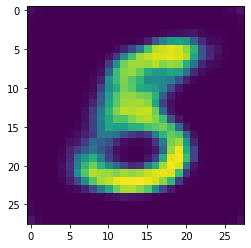

Epoch 0: Loss 7543.234375


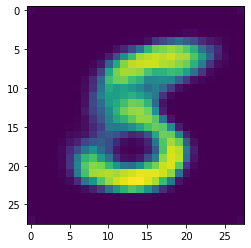

Epoch 1: Loss 6467.80810546875


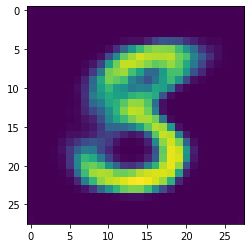

Epoch 2: Loss 6707.1279296875


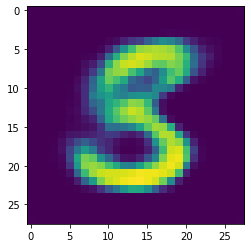

Epoch 3: Loss 6605.6611328125


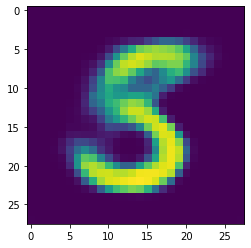

Epoch 4: Loss 6188.3994140625


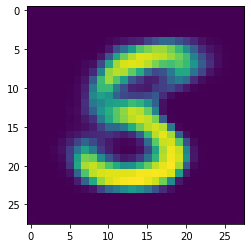

Epoch 5: Loss 6270.37646484375


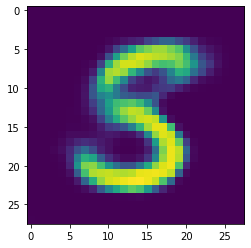

Epoch 6: Loss 6099.77734375


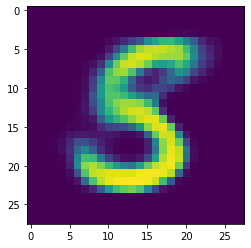

Epoch 7: Loss 6324.82275390625


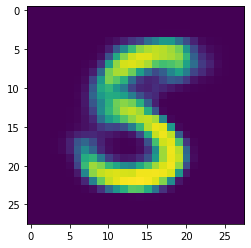

Epoch 8: Loss 6322.6533203125


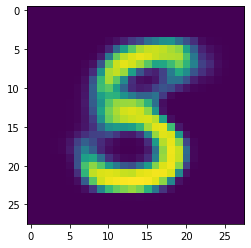

Epoch 9: Loss 6106.45068359375


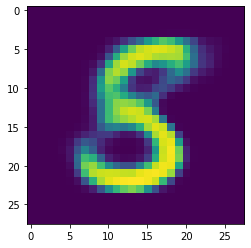

Epoch 10: Loss 6259.94775390625


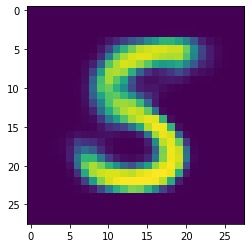

Epoch 11: Loss 6091.22607421875


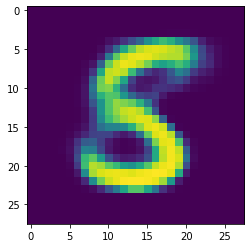

Epoch 12: Loss 6066.50390625


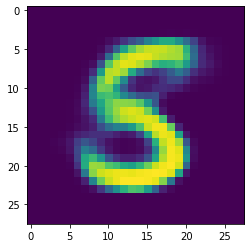

Epoch 13: Loss 6043.013671875


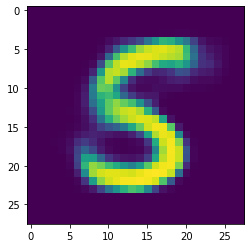

Epoch 14: Loss 6120.439453125


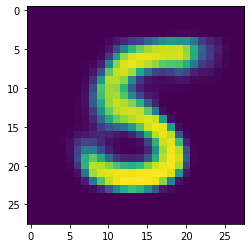

Epoch 15: Loss 6103.1064453125


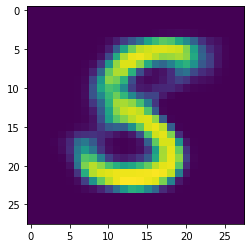

Epoch 16: Loss 6138.4814453125


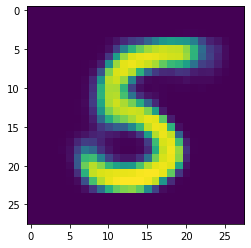

Epoch 17: Loss 6456.5400390625


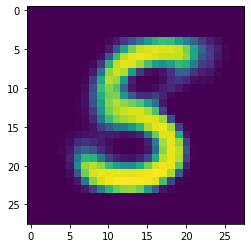

Epoch 18: Loss 5791.3466796875


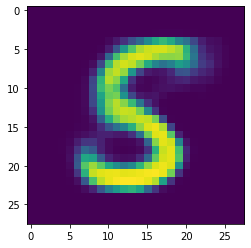

Epoch 19: Loss 5734.06005859375


In [ ]:
net = VAE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

loss_kl_divergence_aver = []
loss_func_aver = []
total_loss_aver = []

for epoch in range(num_epochs):
    loss_kl_divergence = 0
    loss_func = 0
    total_loss = 0
    for idx, data in enumerate(trainloader, 0):
        imgs, _ = data
        imgs = imgs.to(device)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = net(imgs)

        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence

        loss_kl_divergence += kl_divergence
        loss_func += F.binary_cross_entropy(out, imgs, size_average=False)
        total_loss += loss

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_kl_divergence_aver.append((loss_kl_divergence/len(trainloader)).cpu().detach().numpy())
    loss_func_aver.append((loss_func/len(trainloader)).cpu().detach().numpy())
    total_loss_aver.append((total_loss/len(trainloader)).cpu().detach().numpy())

    net.eval()
    with torch.no_grad():
        item = dataset_test[1234][0].view(1, 1, 28, 28).to(device)
        plt.imshow(net(item)[0].view(28, 28).cpu().detach().numpy())
        plt.show()
    net.train()

    print('Epoch {}: Loss {}'.format(epoch, loss))

## Learning curve

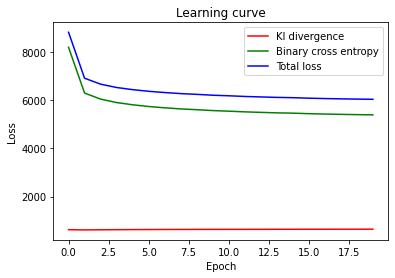

In [ ]:
##Learning curve
plt.plot(loss_kl_divergence_aver, 'r')
plt.plot(loss_func_aver, 'g')
plt.plot(total_loss_aver, 'b')
plt.legend(['Kl divergence','Binary cross entropy', 'Total loss'])
plt.title("Learning curve")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Save model

In [ ]:
torch.save(net, "model_VAE")

## Testing

### Image recovery

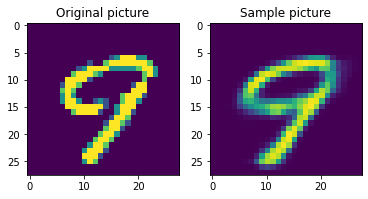

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

net.eval()
fig = plt.figure()
with torch.no_grad():
  data = random.sample(list(testloader), 1)
  imgs = data[0][0].to(device)
  img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
  ax1 = fig.add_subplot(121)
  ax1.imshow(np.squeeze(img))
  out, mu, logVAR = net(imgs)
  outimg = np.transpose(out[0].cpu().detach().numpy(), [1,2,0])
  ax2 = fig.add_subplot(122)
  ax2.imshow(np.squeeze(outimg))

  ax1.title.set_text('Оriginal picture')
  ax2.title.set_text('Sample picture')

  plt.show()

### Generating nonexistent digits from a normal distribution

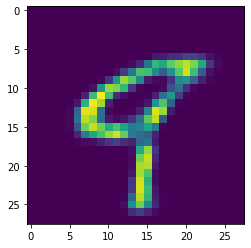

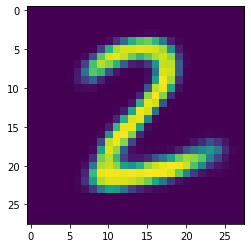

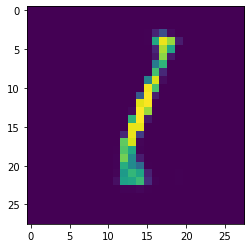

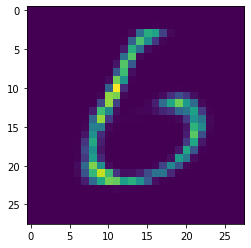

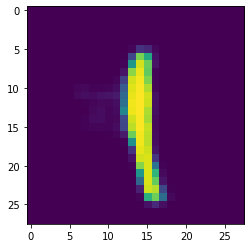

In [ ]:
net.eval()
with torch.no_grad():
    for _ in range(5):
        hidden = torch.normal(torch.zeros((1, 8)), torch.ones((1, 8))).to(device)
        plt.imshow(net.decoder(hidden).view(28, 28).cpu().detach().numpy())
        plt.show()

## Conclusion

The problem <b>of generating non-existent digits from a normal distribution</b> is considered.

A variational atoencoder with convolutional and fully connected layers was implemented. The hyperparameters were chosen empirically. The model is trained on 20 epochs. As a result, the resulting model is able to generate numbers based on the normal distribution. To improve the quality of this model, the following approaches can be considered:
<ul>
  <li>Working with hidden(reducing it)</li>
  <li>More fine-grained work with hyperparameters</li>
  <li>PCA\t-SNE application</li>
</ul>